# Assignment 4: Populations
In our last assignment, we used systematic experimentation to figure out how and why our hillclimber was working -- paying particular attention to how we modify selection pressure, and how that affects search trajectories over fitness landscapes of varying ruggedness.  

In this assignment, we'll continue to build out the basic backbone of our evolutionary algorithm, while applying the same lens of systematic investigation and exploration around implementation details.  In particular, we'll expand our single-parent/single-child hillclimber into a full population, and explore how crossover and selection manifest themselves in our algorithm. 

In [1]:
# imports
import numpy as np
import copy
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import scikits.bootstrap as bootstrap
import warnings
warnings.filterwarnings('ignore') # Danger, Will Robinson! (not a scalable hack, and may surpress other helpful warning other than for ill-conditioned bootstrapped CI distributions)

import scipy.stats # for finding statistical significance
import random

### Q1: Implementing Individuals within a Population
As we beging to work with populations, it will get a increasingly messy to keep track of each individual's genome and fitness seperately as they move around the population and through generational time. To help simplify this, let's implement each individual within a population as an instance of an `Individual` class.  To start, this class will be quite simple and will just be an object which has attributes for both the individual's `genome` and its `fitness`.  Since we will only be using fitness functions that depend on a single individual in this assignment, let's also implement an `eval_fitness` for each individual that will evaluate and update its stored fitness value when called.

In [2]:
class Individual:
    
    def __init__(self, fitness_function, bit_string_length):
        self.genome = []
        for i in range(bit_string_length):
            self.genome.append(random.randint(0,1))
        self.fitness_function = fitness_function
        self.fitness = self.eval_fitness()
        
        
    def eval_fitness(self):
        self.fitness = self.fitness_function(self.genome)

### Q2: Modifying the hillclimber
Let's take the basic hillclimber from our last assignment and turn it into a full fleged evolutionary algorithm.  Again, please feel free to leverage your prior work (or our prior solution sets) and copy-and-paste liberally.  

In particular, our first version of this algorithm will have a number of parents and a number of children given as parameters (a la evolutionary strategies), two-point crossover (of randomly selected parents), and truncation selection.  Please also include arguemtns to this evolutionary_algorithm function which allow you dictate whether the algorithm will use mutation (the same single bit flip we used before), crossover, or both (for use in the following question).

To get a finer-grain look at convergence rates of these different approaches, let's also modify the output of this function to return the fitness of the top individual at each generation.

In [3]:
def evolutionary_algorithm(fitness_function=None, total_generations=100, num_parents=10, num_children=10, bit_string_length=10, num_elements_to_mutate=1, crossover=True):
    """ Evolutinary Algorithm (copied from the basic hillclimber in our last assignment)
        
        parameters: 
        fitness_function: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        total_generations: (int) number of total iterations for stopping condition
        num_parents: (int) the number of parents we downselect to at each generation (mu)
        num_children: (int) the number of children (note: parents not included in this count) that we baloon to each generation (lambda)
        bit_string_length: (int) length of bit string genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation (0 = no mutation)
        crossover (bool): whether to perform crossover when generating children 
        
        returns:
        fitness_over_time: (numpy array) track record of the top fitness value at each generation
    """

    # initialize record keeping
    best = {'fitness':0, 'genome': []}
    fitness_over_time = []
    best_over_time = []
    
    # the initialization proceedure
    parents = []
    children = []
    for i in range(num_parents):
        parents.append({'fitness': 0, 'genome': []})
        for j in range(bit_string_length):
            parents[i]['genome'].append(random.randint(0,1))
    
    # get population fitness
    for i in range(num_parents):
        parents[i]['fitness'] = fitness_function(parents[i]['genome'])
#         if parents[i]['fitness'] > best['fitness']:
#             best = parents[i].copy()
    
    for i in range(total_generations): # repeat
        
        # the modification procedure
        children = []
        
        # inheretance
        if not crossover:
            children = parents.copy()
            
        # crossover
        if crossover:
            while len(children)<num_children:
                random.shuffle(parents)
                for j in range(0, num_parents, 2):

                    # select both parents
                    first_parent = parents[j]
                    second_parent = parents[j+1]
                
                    # randomly select a point for crossover
                    crossover_points = random.sample(range(0,bit_string_length), 2)
                    crossover_points = sorted(crossover_points)
                    
                    # switch genes between these two points between the two individuals
                    child1 = {'fitness': 0, 'genome': parents[j]['genome'][:crossover_points[0]] + parents[j+1]['genome'][crossover_points[0]:crossover_points[1]] + parents[j]['genome'][crossover_points[1]:]}
                    child2 = {'fitness': 0, 'genome': parents[j+1]['genome'][:crossover_points[0]] + parents[j]['genome'][crossover_points[0]:crossover_points[1]] + parents[j+1]['genome'][crossover_points[1]:]}
                    
                    # Do we only keep the best of the parents and children?
                    child1['fitness'] = fitness_function(child1['genome'])
                    child2['fitness'] = fitness_function(child2['genome'])
                    family = [child1, child2, parents[j].copy(), parents[j+1].copy()]
                    family = sorted(family, key=lambda x: x['fitness'], reverse=True)
                    children.append(family[0])
                    children.append(family[1])
                    
                    # Or do we just keep the children no matter what
#                     children.append(child1)
#                     children.append(child2)
                    
            
            if len(children) > num_children:
                children = children[:num_children]
            
        # mutation
        if num_elements_to_mutate > 0:
            # loop through each child
            for j in range(num_children):
                
                # store the current genome for comparison
                current = children[j].copy()
                
                # set fitness value back to zero since this will change
                children[j]['fitness'] = 0
                
                # create storage array for elements to mutate
                elements_mutated = []
                elements_mutated = random.sample(range(0,bit_string_length), num_elements_to_mutate)
                        
                # loop through the array of indices to be mutated
                for k in range(len(elements_mutated)):
                    # set the bit to the opposite of what it currently is
                    if children[j]['genome'][elements_mutated[k]] == 0:
                        children[j]['genome'][elements_mutated[k]] = 1
                    else:
                        children[j]['genome'][elements_mutated[k]] = 0
                
                # Do we only keep the good mutations?
                # set the child to the best of original form vs mutated form
                if current['fitness'] > fitness_function(children[j]['genome']):
                    children[j] = current.copy() 
                    
                # or do we keep the mutation no matter what?
#                 children[j] = children[j]
            
            
        # the assessement procedure
        for j in range(num_children):
            if children[j]['fitness'] == 0:
                children[j]['fitness'] = fitness_function(children[j]['genome'])

        # selection procedure
        parents = children.copy()
        parents = sorted(parents, key=lambda x: x['fitness'], reverse=True)
        parents = parents[:num_parents]
        
        # record keeping
        fitness_over_time.append(parents[0]['fitness'])
        best_over_time.append(parents[0].copy())
        if (parents[0]['fitness']) > best['fitness']:
            best = parents[0].copy()
    
    return fitness_over_time

### Q3: Running Experiments
Similar to last week, let's systemtically run and plot the results.  To start let's use `50` parents (mu) and `50` children (lambda).  For simplicity, let's go back to the one-max problem (and normalize the fitness, using `np.mean` isntead of `np.sum` for our fitness function in case we want to make comparisons across different genome lengths -- though for now, let's start with a bit string genome of length `200`).  

Also taking pieces from your experimental comparison scripts from last week, please run this for the the case of mutation only, crossover only, and employing both mutation and crossover.  Run `20` independent repitions for each condition.

In [4]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
bit_string_length = 200
num_parents = 50
num_children = 50
fitness_function = np.mean
experiment_results = {}

experiment_results['mutation_only'] = []
experiment_results['crossover_only'] = []
experiment_results['crossover_and_mutation'] = []

for i in range(num_runs):
    # mutation only
    m_only = evolutionary_algorithm(fitness_function, total_generations, num_parents, num_children, bit_string_length, num_elements_to_mutate, False)
    experiment_results['mutation_only'].append(m_only)
    
    # crossover only
    c_only = evolutionary_algorithm(fitness_function, total_generations, num_parents, num_children, bit_string_length, 0, True)
    experiment_results['crossover_only'].append(c_only)
    
    # both crossover and mutation
    c_and_m = evolutionary_algorithm(fitness_function, total_generations, num_parents, num_children, bit_string_length, num_elements_to_mutate, True)
    experiment_results['crossover_and_mutation'].append(c_and_m)
    


### Q3b: Visualization
We will also modify our plotting scripts from before to show how fitness increases over generational time across these three treatments (with boostrapped confidence intervals as before).  As we also did previously, please plot the three experimental conditions run above on the same figure for ease of comparisons.

[array([0.5795 , 0.59425]), array([0.581, 0.596]), array([0.5835 , 0.59825]), array([0.58375, 0.599  ]), array([0.58475, 0.5995 ]), array([0.58525, 0.60025]), array([0.58625, 0.60075]), array([0.58725, 0.602  ]), array([0.58775, 0.604  ]), array([0.588  , 0.60375]), array([0.58875, 0.6045 ]), array([0.58925, 0.605  ]), array([0.58925, 0.60475]), array([0.59025, 0.6055 ]), array([0.59075, 0.606  ]), array([0.591  , 0.60625]), array([0.591  , 0.60625]), array([0.591  , 0.60625]), array([0.59075, 0.606  ]), array([0.591  , 0.60675]), array([0.5915 , 0.60675]), array([0.59225, 0.60775]), array([0.592  , 0.60725]), array([0.59225, 0.6075 ]), array([0.59225, 0.6075 ]), array([0.59225, 0.60775]), array([0.592, 0.607]), array([0.59225, 0.60775]), array([0.59225, 0.6075 ]), array([0.592  , 0.60775]), array([0.5925 , 0.60775]), array([0.5925, 0.608 ]), array([0.5925, 0.608 ]), array([0.5925 , 0.60825]), array([0.59225, 0.60775]), array([0.593  , 0.60825]), array([0.593  , 0.60875]), array([0.593

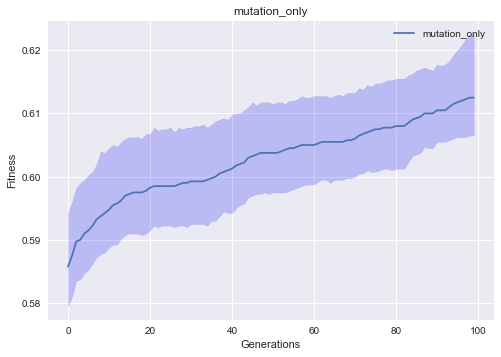

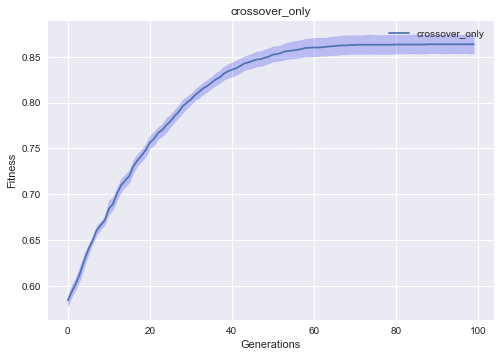

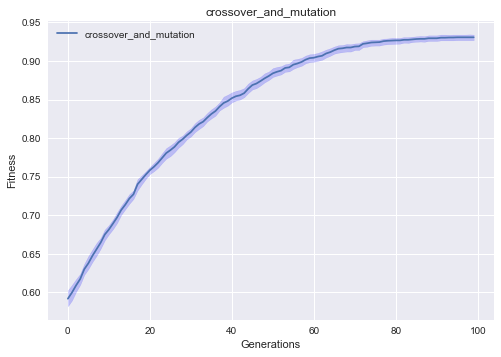

In [5]:
def plot_mean_and_bootstrapped_ci_over_time(input_data = None, name = "change me", x_label = "change me", y_label="change me", y_limit = None):
    """
    
    parameters: 
    input_data: (numpy array of shape (generations, num_repitions)) solution metric to plot
    name: (string) name for legend
    x_label: (string) x axis label
    y_label: (string) y axis label
    
    returns:
    None
    """

    generations = input_data.shape[0]

    CIs = []
    mean_values = []
    for i in range(generations):
        mean_values.append(np.mean(input_data[i]))
        CIs.append(bootstrap.ci(input_data[i], statfunction=np.mean))
    mean_values=np.array(mean_values)
    
    print(CIs)
    high = []
    low = []
    for i in range(len(CIs)):
        low.append(CIs[i][0])
        high.append(CIs[i][1])
    
    low = np.array(low)
    high = np.array(high)
    fig, ax = plt.subplots()
    y = range(0, generations)
    ax.plot(y, mean_values, label=name)
    ax.fill_between(y, high, low, color='b', alpha=.2)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()
    if (name) and len(name)>0:
        ax.set_title(name)
    
    
plot_mean_and_bootstrapped_ci_over_time(input_data=np.transpose(np.array(experiment_results['mutation_only'])), name='mutation_only', y_label="Fitness", x_label='Generations')
plot_mean_and_bootstrapped_ci_over_time(input_data=np.transpose(np.array(experiment_results['crossover_only'])), name='crossover_only', y_label="Fitness", x_label='Generations')
plot_mean_and_bootstrapped_ci_over_time(input_data=np.transpose(np.array(experiment_results['crossover_and_mutation'])), name='crossover_and_mutation', y_label="Fitness", x_label='Generations')


### Q4: Analysis of Crossover
Is crossover effective on this problem? How does crossover compare to mutation?  How do the two interact? 

**Crossover is effective depending on implementation. If we only allow positive crossover, where we keep the two best family members (between 2 parents and 2 offspring), then we get a highly effective algorithm. If, on the other hand, we keep negative or positive, we get some jumping around regarding fitness on this problem. This is because crossover makes rather large changes compared to a rather small mutation rate. Crossover can jump much farther in the fitness landscape than mutations. Mutations only does show a positive effect if we keep only positive mutations and do not allow negative ones. The reason that this strategy with both crossover and mutations works well for this problem is due to the simplicity of the fitness landscape. Crossover and mutation can interact together by building upon one another toward a more fit solution. 
The results above are obtained by only allowing positive crossover and positive mutation. This can change drastically when allowing both positive and negative crossover and/or mutation. Crossover makes the fitness bounce around pretty drastically in this case, and mutations make the fitness stay rather close to it's original value but still bouncing around on a smaller scale.**

### Q5: Propose and Implement a New Crossover Modification
We've implemented one specfic type of crossover (two-point crossover with two randomly chosen parents).  What other variatons to crossover might you consider?  Describe it in the box below, and what you anticipate as the effects of it (positive or negative).

**I propose uniform crossover only allowing positive children. Uniform crossover involves traversing over each gene in the genome and with some probability choosing the first parent's or second parent's allele for it. In this case, we will choose each parent's allele with a 50% probability. I anticipate that the effects will be similar to what we see above. My reasoning is that since we are only allowing positive children, we will have a very similar trajectory depending on how lucky/unlucky we are with our probabilities on choosing the better allele.**

### Q5b: Let's test it!
Copy your evoluationary_algoirthm code and modify it to include your new experimental treatment.  Run and visualize this treatment as above.  Feel free to alo pull in any statistical test scripts/functions from last week, should that help you to analyze and compare this new approach.

In [6]:
# your new evolutionary_algorithm
def evolutionary_algorithm(fitness_function=None, total_generations=100, num_parents=10, num_children=10, bit_string_length=10, num_elements_to_mutate=1, crossover=True):
    """ Evolutinary Algorithm (copied from the basic hillclimber in our last assignment)
        
        parameters: 
        fitness_function: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        total_generations: (int) number of total iterations for stopping condition
        num_parents: (int) the number of parents we downselect to at each generation (mu)
        num_children: (int) the number of children (note: parents not included in this count) that we baloon to each generation (lambda)
        bit_string_length: (int) length of bit string genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation (0 = no mutation)
        crossover (bool): whether to perform crossover when generating children 
        
        returns:
        fitness_over_time: (numpy array) track record of the top fitness value at each generation
    """

    # initialize record keeping
    best = {'fitness':0, 'genome': []}
    fitness_over_time = []
    best_over_time = []
    
    # the initialization proceedure
    parents = []
    children = []
    for i in range(num_parents):
        parents.append({'fitness': 0, 'genome': []})
        for j in range(bit_string_length):
            parents[i]['genome'].append(random.randint(0,1))
    
    # get population fitness
    for i in range(num_parents):
        parents[i]['fitness'] = fitness_function(parents[i]['genome'])
#         if parents[i]['fitness'] > best['fitness']:
#             best = parents[i].copy()
    
    for i in range(total_generations): # repeat
        
        # the modification procedure
        children = []
        
        # inheretance
        if not crossover:
            children = parents.copy()
            
        # crossover
        if crossover:
            while len(children)<num_children:
                random.shuffle(parents)
                for j in range(0, num_parents, 2):

                    # select both parents
                    first_parent = parents[j]
                    second_parent = parents[j+1]
                
                    # randomly select a point for crossover
                    crossover_points = random.sample(range(0,bit_string_length), 2)
                    crossover_points = sorted(crossover_points)
                    
                    # switch the tail end of the genomes at this point between the two individuals
                    child1 = {'fitness': 0, 'genome': []}
                    child2 = {'fitness': 0, 'genome': []}
                    for k in range(bit_string_length):
                        child1['genome'].append(parents[random.randint(j,j+1)]['genome'][k])
                        child2['genome'].append(parents[random.randint(j,j+1)]['genome'][k])
                    child1['fitness'] = fitness_function(child1['genome'])
                    child2['fitness'] = fitness_function(child2['genome'])
                    
                    # Do we only keep the best of the parents and children?
                    family = [child1, child2, parents[j].copy(), parents[j+1].copy()]
                    family = sorted(family, key=lambda x: x['fitness'], reverse=True)
                    children.append(family[0])
                    children.append(family[1])
                    
                    # Or do we just keep the children no matter what
#                     children.append(child1)
#                     children.append(child2)
                    
            
            if len(children) > num_children:
                children = children[:num_children]
            
        # mutation
        if num_elements_to_mutate > 0:
            # loop through each child
            for j in range(num_children):
                
                # store the current genome for comparison
                current = children[j].copy()
                
                # set fitness value back to zero since this will change
                children[j]['fitness'] = 0
                
                # create storage array for elements to mutate
                elements_mutated = []
                elements_mutated = random.sample(range(0,bit_string_length), num_elements_to_mutate)
                        
                # loop through the array of indices to be mutated
                for k in range(len(elements_mutated)):
                    # set the bit to the opposite of what it currently is
                    if children[j]['genome'][elements_mutated[k]] == 0:
                        children[j]['genome'][elements_mutated[k]] = 1
                    else:
                        children[j]['genome'][elements_mutated[k]] = 0
                
                # Do we only keep the good mutations?
                # set the child to the best of original form vs mutated form
                if current['fitness'] > fitness_function(children[j]['genome']):
                    children[j] = current.copy() 
                    
                # or do we keep the mutation no matter what?
#                 children[j] = children[j]
            
            
        # the assessement procedure
        for j in range(num_children):
            if children[j]['fitness'] == 0:
                children[j]['fitness'] = fitness_function(children[j]['genome'])

        # selection procedure
        parents = children.copy()
        parents = sorted(parents, key=lambda x: x['fitness'], reverse=True)
        parents = parents[:num_parents]
        
        # record keeping
        fitness_over_time.append(parents[0]['fitness'])
        best_over_time.append(parents[0].copy())
        if (parents[0]['fitness']) > best['fitness']:
            best = parents[0].copy()
    
    return fitness_over_time

In [7]:
# experimentation
# num_runs = 20
# total_generations = 100
# num_elements_to_mutate = 1
# bit_string_length = 200
# num_parents = 50
# num_children = 50
# fitness_function = np.mean
# experiment_results = {}

experiment_results['mutation_only'] = []
experiment_results['crossover_only'] = []
experiment_results['crossover_and_mutation'] = []

for i in range(num_runs):
    # mutation only
    m_only = evolutionary_algorithm(fitness_function, total_generations, num_parents, num_children, bit_string_length, num_elements_to_mutate, False)
    experiment_results['mutation_only'].append(m_only)
    
    # crossover only
    c_only = evolutionary_algorithm(fitness_function, total_generations, num_parents, num_children, bit_string_length, 0, True)
    experiment_results['crossover_only'].append(c_only)
    
    # both crossover and mutation
    c_and_m = evolutionary_algorithm(fitness_function, total_generations, num_parents, num_children, bit_string_length, num_elements_to_mutate, True)
    experiment_results['crossover_and_mutation'].append(c_and_m)
    

[array([0.5755, 0.5865]), array([0.57675, 0.588  ]), array([0.57825, 0.58925]), array([0.57875, 0.59   ]), array([0.5795, 0.591 ]), array([0.57925, 0.59075]), array([0.581  , 0.59175]), array([0.582  , 0.59325]), array([0.58225, 0.593  ]), array([0.583  , 0.59375]), array([0.58325, 0.59375]), array([0.58425, 0.5945 ]), array([0.5845, 0.5945]), array([0.5845, 0.5945]), array([0.5855, 0.595 ]), array([0.5865 , 0.59575]), array([0.5875 , 0.59625]), array([0.5885 , 0.59675]), array([0.58875, 0.597  ]), array([0.5885, 0.597 ]), array([0.58875, 0.59725]), array([0.589  , 0.59725]), array([0.589  , 0.59725]), array([0.589  , 0.59725]), array([0.589  , 0.59725]), array([0.589 , 0.5975]), array([0.589  , 0.59725]), array([0.58925, 0.59775]), array([0.58925, 0.59775]), array([0.58925, 0.59775]), array([0.58925, 0.598  ]), array([0.5895 , 0.59875]), array([0.58975, 0.599  ]), array([0.59 , 0.599]), array([0.58975, 0.599  ]), array([0.58975, 0.599  ]), array([0.58975, 0.599  ]), array([0.58975, 0.

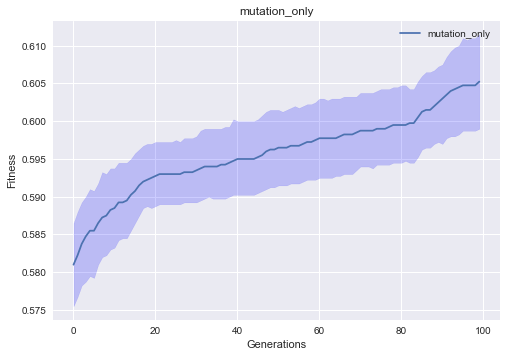

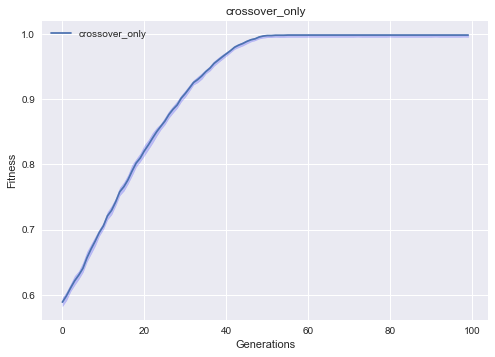

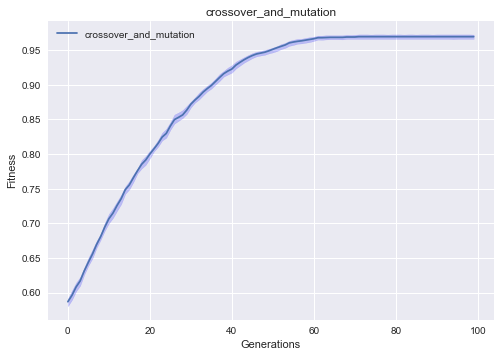

In [8]:
# visualization
plot_mean_and_bootstrapped_ci_over_time(input_data=np.transpose(np.array(experiment_results['mutation_only'])), name='mutation_only', y_label="Fitness", x_label='Generations')
plot_mean_and_bootstrapped_ci_over_time(input_data=np.transpose(np.array(experiment_results['crossover_only'])), name='crossover_only', y_label="Fitness", x_label='Generations')
plot_mean_and_bootstrapped_ci_over_time(input_data=np.transpose(np.array(experiment_results['crossover_and_mutation'])), name='crossover_and_mutation', y_label="Fitness", x_label='Generations')

### Q6: Well... What happened?
Describe the effect of your approach.  If it did not work out as expected, please hypotheize as to why this is the case.  If it did work out well, please comment on how broadly you think this finding might apply (or in what experimental conditions you might expect to come to a different conclusion). 

**This worked out better than I thought it would. Crossover alone was able to find the optimal solution after about 50 generations. This means that the uniform crossover worked very well in maximizing sum of the bits. This makes sense to me now since I am choosing the best of the family members, not just the best of the children in my crossover loop. Meaning we have a decent chance to make fairly large jumps in our fitness landscape compared to 2-point crossover. This is because potentially, uniform crossover can produce a bit string of all ones on the first try, whereas, this isn't even a possibility for something like 2-point crossover in most cases. 2-point crossover can only work with the alleles that exist within the two parents that it is looking at. It will also only change the genes between the two random points it has chosen. This makes the uniform crossover a bit more exploratory in this regard, meaning that sometimes it will find better solutions. This fitness landscape may have been an advatageous place for positive uniform crossover because of it's simplicity.**

### Q7: Implementing Tournament Selection
Aside from crossover, including populations also gives us the opportunity to explore alternate selection mechanisms.  As mentioned in class, tournament selection is one of my go-to methods for parent selection, so let's implement it here.  The tournament should rely on input parameters such as the `tournament_size` to determine how many solutions will compete in a given tournament or  `num_tournament_winners` to determine how many individuals from each tournament will be selected to move on as parents of the next generation.  Touraments can be selected from the population with or without replacement (specifically I'm referring to making sure all individuals appear in at least one tournament before any individual partakes in one for a second time), and here feel free to use whichever version is simpler for you to implement and understand (which I expect will be the case with replacement).  

In [9]:
def evolutionary_algorithm(fitness_function=None, total_generations=100, num_parents=10, num_children=10, bit_string_length=10, num_elements_to_mutate=1, crossover=True, tournament_size=4, num_tournament_winners=2):
    """ Evolutinary Algorithm (copied from the basic hillclimber in our last assignment)
        
        parameters: 
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        total_generations: (int) number of total iterations for stopping condition
        num_parents: (int) the number of parents we downselect to at each generation (mu)
        num_childre: (int) the number of children (note: parents not included in this count) that we baloon to each generation (lambda)
        bit_string_length: (int) length of bit string genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation (0 = no mutation)
        crossover: (bool) whether to perform crossover when generating children 
        tournament_size: (int) number of individuals competing in each tournament
        num_tournament_winners: (int) number of individuals selected as future parents from each tournament (must be less than tournament_size)
        
        returns:
        fitness_over_time: (numpy array) track record of the top fitness value at each generation
    """

    # initialize record keeping
    best = {'fitness':0, 'genome': []}
    fitness_over_time = []
    best_over_time = []
    
    # the initialization proceedure
    parents = []
    children = []
    for i in range(num_parents):
        parents.append({'fitness': 0, 'genome': []})
        for j in range(bit_string_length):
            parents[i]['genome'].append(random.randint(0,1))
    
    # get population fitness
    for i in range(num_parents):
        parents[i]['fitness'] = fitness_function(parents[i]['genome'])
#         if parents[i]['fitness'] > best['fitness']:
#             best = parents[i].copy()
    
    for i in range(total_generations): # repeat
        
        # the modification procedure
        children = []
        
        # inheretance
        if not crossover:
            children = parents.copy()
            
        # crossover
        if crossover:
            while len(children)<num_children:
                random.shuffle(parents)
                for j in range(0, num_parents, 2):

                    # select both parents
                    first_parent = parents[j]
                    second_parent = parents[j+1]
                
                    # randomly select a point for crossover
                    crossover_points = random.sample(range(0,bit_string_length), 2)
                    crossover_points = sorted(crossover_points)
                    
                    # switch genes between these two points between the two individuals
                    child1 = {'fitness': 0, 'genome': parents[j]['genome'][:crossover_points[0]] + parents[j+1]['genome'][crossover_points[0]:crossover_points[1]] + parents[j]['genome'][crossover_points[1]:]}
                    child2 = {'fitness': 0, 'genome': parents[j+1]['genome'][:crossover_points[0]] + parents[j]['genome'][crossover_points[0]:crossover_points[1]] + parents[j+1]['genome'][crossover_points[1]:]}
                    
                    child1['fitness'] = fitness_function(child1['genome'])
                    child2['fitness'] = fitness_function(child2['genome'])
                    
                    # Do we only keep the best of the parents and children?
                    family = [child1, child2, parents[j].copy(), parents[j+1].copy()]
                    family = sorted(family, key=lambda x: x['fitness'], reverse=True)
                    children.append(family[0])
                    children.append(family[1])
                    
                    # Or do we just keep the children no matter what
#                     children.append(child1)
#                     children.append(child2)
                    
            
            if len(children) > num_children:
                children = children[:num_children]
            
        # mutation
        if num_elements_to_mutate > 0:
            # loop through each child
            for j in range(num_children):
                
                # store the current genome for comparison
                current = children[j].copy()
                
                # set fitness value back to zero since this will change
                children[j]['fitness'] = 0
                
                # create storage array for elements to mutate
                elements_mutated = []
                elements_mutated = random.sample(range(0,bit_string_length), num_elements_to_mutate)
                        
                # loop through the array of indices to be mutated
                for k in range(len(elements_mutated)):
                    # set the bit to the opposite of what it currently is
                    if children[j]['genome'][elements_mutated[k]] == 0:
                        children[j]['genome'][elements_mutated[k]] = 1
                    else:
                        children[j]['genome'][elements_mutated[k]] = 0
                
                # Do we only keep the good mutations?
                # set the child to the best of original form vs mutated form
                if current['fitness'] > fitness_function(children[j]['genome']):
                    children[j] = current.copy() 
                    
                # or do we keep the mutation no matter what?
#                 children[j] = children[j]
            
            
        # the assessement procedure
        for j in range(num_children):
            if children[j]['fitness'] == 0:
                children[j]['fitness'] = fitness_function(children[j]['genome'])

        # selection procedure
        parents = children.copy()
        random.shuffle(parents)
        new_parents = []
        
        # loop for the number of parents that we want
        while len(new_parents) < num_parents:
            random.shuffle(parents)
            for j in range(0, num_parents, tournament_size):
                winners = []
                for k in range(0, tournament_size):
                    if len(parents) <= j+k:
                        winners.append(parents[random.randint(0,len(parents)-1)])
                    else:
                        winners.append(parents[j+k])
                winners = sorted(winners, key=lambda x: x['fitness'], reverse=True)
                winners = winners[:num_tournament_winners]
                new_parents += winners
        
        parents = sorted(new_parents, key=lambda x: x['fitness'], reverse=True)[:num_parents]
        
        # record keeping
        fitness_over_time.append(parents[0]['fitness'])
        best_over_time.append(parents[0].copy())
        if (parents[0]['fitness']) > best['fitness']:
            best = parents[0].copy()
    
    return fitness_over_time

### Q8: Run and Plot
We discussed in class that the number of individuals participating in a tournament affects the amount of selection pressure it produces, presumably the same is true for the number of individuals selected from that tournament.  So let's play around and generate some data to try and get to the bottom of it!  In particular, let's run the following four experimental conditions: `10 select 5`, `20 select 10`, `20 select 5`, `50 select 10` (where the first number is how many individuals are in a tournament, and the second number is how many are selected from that tournament).  Let's run these on the full-fledged evolutionary_algorithm including both mutation and crossover (for consistency and ease of grading please the original evolutionary algorithm implementation from `Q2` rather than your new implementation in `Q5` by either rerunning the prior code block, or by coping and pasting it in a new code block below).  As above, please visualize the resulting fitnes over time and their boostrapped confidence intervals as well.

In [10]:
# if wanting to copy the original evolutionary_algorithm implementation here (e.g. so you can run Kernel -> Restart & Run All without having to manually rerun the block above within that)
... 

In [11]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
bit_string_length = 200
num_parents = 50
num_children = 50
fitness_function = np.mean

experiment_results['10_select_5'] = []
experiment_results['20_select_10'] = []
experiment_results['50_select_10'] = []

for i in range(num_runs):
    # 10 select 5
    ten_select_5 = evolutionary_algorithm(fitness_function, total_generations, num_parents, num_children, bit_string_length, num_elements_to_mutate, True, 10, 5)
    experiment_results['10_select_5'].append(ten_select_5)
    
    # 20 select 10
    twenty_select_10 = evolutionary_algorithm(fitness_function, total_generations, num_parents, num_children, bit_string_length, num_elements_to_mutate, True, 20, 10)
    experiment_results['20_select_10'].append(twenty_select_10)
    
    # both crossover and mutation
    fifty_select_10 = evolutionary_algorithm(fitness_function, total_generations, num_parents, num_children, bit_string_length, num_elements_to_mutate, True, 50, 10)
    experiment_results['50_select_10'].append(fifty_select_10)
    

[array([0.57475, 0.5845 ]), array([0.5915 , 0.60675]), array([0.61325, 0.62525]), array([0.6315 , 0.64225]), array([0.64425, 0.656  ]), array([0.65825, 0.67175]), array([0.67 , 0.684]), array([0.6825 , 0.69575]), array([0.696 , 0.7125]), array([0.705  , 0.71975]), array([0.71875, 0.7325 ]), array([0.726  , 0.74075]), array([0.73475, 0.7485 ]), array([0.742 , 0.7555]), array([0.75175, 0.7665 ]), array([0.75925, 0.77375]), array([0.76625, 0.78175]), array([0.77375, 0.78975]), array([0.7795, 0.795 ]), array([0.7845, 0.8   ]), array([0.792  , 0.80725]), array([0.797 , 0.8105]), array([0.80325, 0.817  ]), array([0.811  , 0.82425]), array([0.8155, 0.8305]), array([0.82025, 0.835  ]), array([0.82275, 0.8375 ]), array([0.82625, 0.843  ]), array([0.83   , 0.84675]), array([0.83625, 0.85175]), array([0.841, 0.857]), array([0.843 , 0.8595]), array([0.84475, 0.862  ]), array([0.8475 , 0.86625]), array([0.8495 , 0.86975]), array([0.8515, 0.8715]), array([0.85175, 0.872  ]), array([0.853 , 0.8735]),

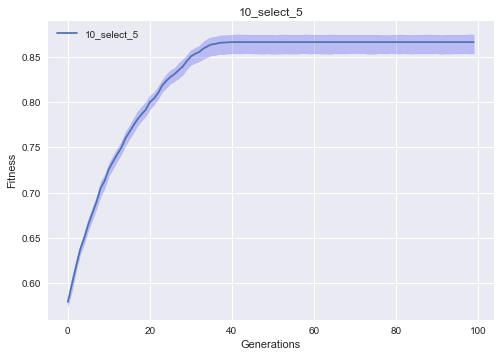

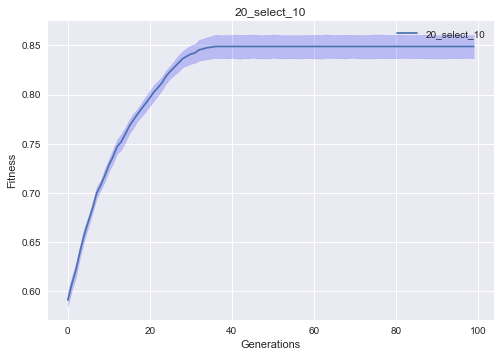

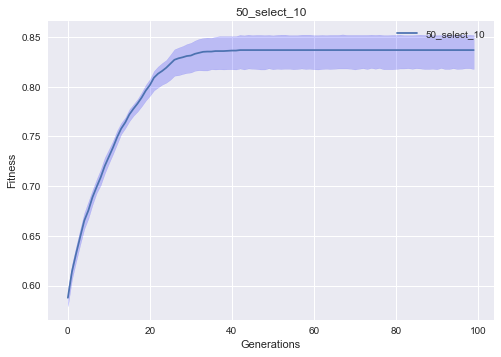

In [12]:
# plotting
plot_mean_and_bootstrapped_ci_over_time(input_data=np.transpose(np.array(experiment_results['10_select_5'])), name='10_select_5', y_label="Fitness", x_label='Generations')
plot_mean_and_bootstrapped_ci_over_time(input_data=np.transpose(np.array(experiment_results['20_select_10'])), name='20_select_10', y_label="Fitness", x_label='Generations')
plot_mean_and_bootstrapped_ci_over_time(input_data=np.transpose(np.array(experiment_results['50_select_10'])), name='50_select_10', y_label="Fitness", x_label='Generations')

### Q9: Analysis
What do these results suggest matter about the values of the tournnament size and the number of winners selected?  Is this suprising?

**The smaller tournament size and selection seems to do the best as far as accuracy goes. I would think that keeping the tournament size smaller would result in more variation as it seems to do here with the confidence intervals showing a bit more exploratory approach. this could be due to the chances that lower fitness genomes are compared to one another is higher if there aren't as many comparisons being made. Having the tournament size larger means that more items are compared to one another giving a higher chance of being compared to a better performing genome. Having the winners be a smaller fraction of the tournament increases selection pressure and exploitation as well. If we have more individuals being kept from a tournament there is a higher chance of keeping lower performing individuals that are exploring a different space in the landscape. **

### Q10: Future Work
Again, we've just scratched the tip of the iceberg in terms of understanding or efficiently employing populations in evolutionary algorithms.  If you were to run one more experiment here (i.e. another question in this assignment) what would you test next?  If you were to deeply investigate some phenomenon around populations/selection/crossover (i.e. spend 6 weeks on a course project) what broader topic might you dig into?

**I would want to play around with the fitness landscape / problem space. I think that having such a simple fitness landscape makes it difficult to understand the effects of these different selection and variation techniques. We can see some of this if we look back at the last assignment. If I was to deeply investigate some phenomenon herein for a number of weeks, I think I would want to investigate selection and/or crossover when applied to a dynamic fitness landscape. What might be the best technique(s) to use in a scenario where our solutions are coevolving along with the fitness landscape. Should we use a dynamic technique for the dynamic landscapes? Is there a "best" way to go about it? Does it depend on the coevolution that is happening?**

### Congratulations, you made it to the end!
Nice work -- and hopefully you're starting to get the hang of these!

Please save this file as a .ipynb, and also download it as a .pdf, uploading **both** to blackboard to complete this assignment.  

For your submission, please make sure that you have renamed this file (and that the resulting pdf follows suit) to replce `[netid]` with your UVM netid.  This will greatly simplify our grading pipeline, and make sure that you receive credit for your work.  

#### Academic Integrity Attribution
During this assignment I collaborated with:

**Just me**